In [540]:
import numpy as np
import torch
import math
import matplotlib.pyplot as plt

# Implementing simple neural network  

- Implement simple neural network with torch
- Understand basics of how inputs, weights, and biases are combined to form outputs.
- Understand how to work with tensors (not exactly same as numpy vectors). Get comfortable
- Understand how activations are calculated for a single input and a single layer  


## Define a neural net (without using nn.Module)  

- Here we do not use torch.nn.Module

A simple neural network with 2 layers: first with 2 neurons and second with 1 neuron. The output is 1X1 and input is 3X1. 


The weight matrix for first layer is shown below with three elements in each row. Each element $w_{jk}^{[1]}$ is the $k^{th}$ weight of the $j^{th}$ neuron in first layer. So, $w_{23}^{[1]}$ is the third weight of the second neuron in the first layer.  

The second weight matrix consists of two elements only. Since there are only two neurons in the previous layer and one neuron in the second layer.

$$\mathbf{W}^{[1]} = \begin{bmatrix}w_{11}^{[1]}&w_{12}^{[1]}&w_{13}^{[1]}\\
                 w_{21}^{[1]}&w_{22}^{[1]}&w_{23}^{[1]}\\
                 \end{bmatrix}$$  
$$\mathbf{W}^{[2]} = \begin{bmatrix}w_{11}^{[2]}&w_{12}^{[2]}
                 \end{bmatrix}$$

In [344]:
# weights of first layer
weights_1 = torch.randn(2,3)
# weights_1.requires_grad_()

# weights of second layer
weights_2 = torch.randn(2, 1)
# weights_2.requires_grad_()

# biases of first layer
biases_1 = torch.ones(2, 1, requires_grad=False)

# biases of second layer
biases_2 = torch.ones(1, 1, requires_grad=False)

print(weights_1.shape, weights_2.shape)

torch.Size([2, 3]) torch.Size([2, 1])


In [153]:
# single input (later we will do with batches)
inputs = torch.randn(3,1)
print(inputs.shape)

torch.Size([3, 1])


## Activation function

In [292]:
def relu(x):
    '''
    Implements ReLU acitvation function
    Returns the ReLU output
    '''
    return x* (x>0)

def sigmoid(x):
    '''
    Implements sigmoid activation
    Returns the sigmoid(x)
    '''
    return 1/(1 + np.exp(-(x.detach())))

## Model  

The `forward()` function had a major issue that is highlighted in comments (see discarded code at the end). Very subtle to detect especially since I have never manually coded a neural network in raw torch and numpy

## Potentially better `forward` method  and way to use it  

This function returns the output of a neuron and not the activation layer. We write the activation separately.

In [262]:
def forward(layer, inputs, weights, biases, print_summary = False):
    '''
    Calculates forward pass for a single layer model (here with 2 inputs and three neurons)  
    
    inputs: Inputs (tensor)
    
    weights: weights of neurons in the layer (tensor)
    
    biases: biases of neurons the layer (tensor)
    
    activ: activation function (function)
    
    layer: Number of layers. This is not removed from the above forward function so that we can print info layerwise.
    
    Returns the output of a layer as a tensor
    '''
    if print_summary == True:
        
        print('==========================================================')
        print('Inputs for layer {}: {}\n'.format(layer, inputs.ravel()))

        print('------------------------------------------------')
        print('biases for layer {}: {}: \n'.format(layer, biases.ravel()))

        print('------------------------------------------------')
        print('Weights for layer {}: {}:\n'.format(layer, weights))

    if weights.shape[1]>1: # for layers which have proper weight matrices (nxm) and not single row of weights
        z = weights@inputs + biases    

    else:
        z = torch.dot(weights.ravel(), inputs.ravel()) + biases.ravel()  # for last layer whose weight matrix is actually a vector
    if print_summary == True:
        print('------------------------------------------------')
        print('Outputs for layer {}: {}\n\n'.format(layer, z))

    return z

The output of the cell below shows the correct manner in which inputs weights and biases should be combined to give outputs and then passed through activation functions to give activations of a layer. Note that the input for layer 2 is same as activation of layer 1.

In [293]:
# we will store each layer's activations 
activ_layers = []

# single input (later we will do with batches)
# inputs = torch.randn(3,1)

weights = [weights_1, weights_2]

# Forward pass
z_1 = forward(1, inputs, weights[0], biases[0], print_summary= True)
a_1 = sigmoid(z_1)
activ_layers.append(a_1)

z_2 = forward(2, a_1, weights[1], biases[1], print_summary= True)
a_2 = sigmoid(z_2)
activ_layers.append(a_2)

print(a_1)
print(a_2)

Inputs for layer 1: tensor([-0.1929, -0.3592,  0.3254])

------------------------------------------------
biases for layer 1: tensor([1.], grad_fn=<ViewBackward0>): 

------------------------------------------------
Weights for layer 1: tensor([[-0.3835, -0.3507, -0.7801],
        [ 0.4779, -1.7902, -0.2003]]):

------------------------------------------------
Outputs for layer 1: tensor([[0.9461],
        [1.4858]], grad_fn=<AddBackward0>)


Inputs for layer 2: tensor([0.7203, 0.8154])

------------------------------------------------
biases for layer 2: tensor([1.], grad_fn=<ViewBackward0>): 

------------------------------------------------
Weights for layer 2: tensor([[ 0.2145],
        [-0.7346]]):

------------------------------------------------
Outputs for layer 2: tensor([0.5555], grad_fn=<AddBackward0>)


tensor([[0.7203],
        [0.8154]])
tensor([0.6354])


## Calculating loss  

Inorder to train a neural network, we need to train the network to calculate a loss value for a given input value. The final loss value of a network is the average of loss values over the entire dataset. The squared error loss or mean square loss is shown below. It is one of many types of loss functions such as cross_entropy, log_loss, hinge_loss, etc.

$$\mathcal{Loss} =  \frac{1}{n}\sum_{i = 1}^n \Big(\hat{y}_i - y\Big)^2$$

In [232]:
def sq_loss(y_pred, y_actual):
    '''
    Returns the sq loss for a given tensor
    x: tensor for which loss it to be evaluated
    '''
    return (y_pred-y_actual)

In [261]:
y_pred

tensor([[0.8826],
        [0.8975]])

In [175]:
loss = sq_loss(activ_layers[-1], 1) # we arbitarily choose actual y to be 1
loss

tensor([0.0111])

## Training  

The next step is to learn how to train this network for a given pair of inputs and outputs.   
We have the forward() method to calculate actiavtions and sq_loss() to calculate loss. We can now inmplement input batches and train the network. We need the following to do that:
- A function that will compute the gradients w.r.t every parameter in our model. Note that this involves calculating gradient via the `chain rule` and hence actually involves gradients of various functions w.r.t intermediate outputs.


- A function that will implement SGD or take the gradients from the previous func and update the parameter  


- A training loop

To compute the gradients, we have three options:

- Compute the gradients using torch.autograd() (`Easiest way`)


- Compute the gradient manually for each parameter in the model (small model so it is doable)  


- Code autograd for this model manually rather than using torch.autograd() (`toughest way`)

We will do all of them and that will take time!!  

*Probably will avoid doing the last one. Feels like reinventing the wheel and also because it is insanely tough. This is after I have completed manually doing the gradient part. That too only for last layer parameters*

## Computational graph of our small network

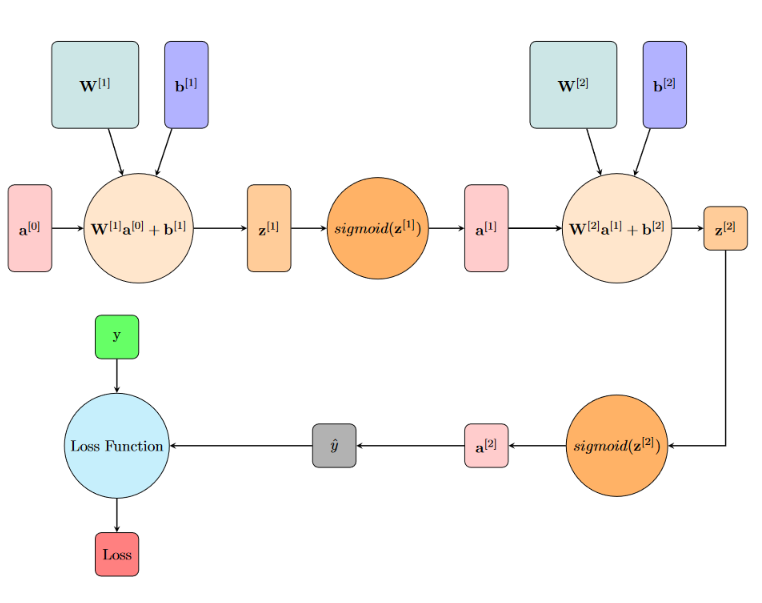

## Gradients in a neural network



$$\mathcal{L}(Loss) = f(\text{activations of last layer and actual output}) = f(\mathbf{y}, \mathbf{\hat{y}})$$  

In general, for the $L^{th}$ layer, $$\text{Activations or } \mathbf{a}^{[L]} = \hat{\mathbf{y}} = \sigma(\mathbf{z}^{[L]}) = \frac{1}{1 + e^{-\mathbf{z}^{[L]}}}$$  

$$\mathbf{z}^{[L]} = f(\mathbf{W}^{[L]}, \mathbf{a}^{[L-1]}, \mathbf{b}^{[L]})$$  

$$\mathbf{z}^{[L]} =  \mathbf{W}^{[L]}\mathbf{a}^{[L-1]} + \mathbf{b}^{[L]}$$  

We expand the terms below, 

$$\mathbf{a}^{[L-1]}  = \big(a_{1}^{[L-1]}, a_{2}^{[L-1]}, .., a_{k}^{[L-1]}\big)$$  

$$\mathbf{W}^{[L]} = \begin{bmatrix}w_{11}^{[L]}&w_{12}^{[L]}&.&.&w_{1k}^{[L]}\\
                                    w_{21}^{[L]}&w_{22}^{[L]}&.&.&w_{2k}^{[L]}\\
                                    .&\\
                                    .&\\
                                    w_{j1}^{[L]}&w_{j2}^{[L]}&.&.&w_{jk}^{[L]}\end{bmatrix}$$


$$\mathbf{z}^{[L]}  = \big(z_{1}^{[L]},  z_{2}^{[L]}, . ., z_{k}^{[L]}\big)$$


#### To train the network, we need to compute gradients w.r.t each of the weights and biases in each layer and update them according to gradient descent algorithm.  

`For our network` with 3 inputs, 2 neurons in first layer (with sigmoid activation), and one neuron in output layer, we have,  

$$\mathcal{Loss} = f(z^{[2]}) = f(f(w_{11}^{[2]}, w_{12}^{[2]}))$$

Refer the figure above to understand the nested nature of the functions.  

Inorder to calculate the update the weigths, we need to calculate the gradient of $\mathcal{Loss}$ w.r.t each of the weights and biases. Here, we first consider the weights and biases of last layer. Here we only have one neuron in the last layer so we need not index the last layer's output and bias with (j,k). Thats why there is no $z_i^{[2]}$ and only $z^{[2]}$


$$\frac{\partial{\mathcal{Loss}}}{\partial{w_{11}^{[2]}}} = \frac{\partial{\mathcal{Loss}}}{\partial{z^{[2]}}}*\frac{\partial{z^{[2]}}}{\partial{w_{11}^{[2]}}}$$  

$$\frac{\partial{\mathcal{Loss}}}{\partial{w_{12}^{[2]}}} = \frac{\partial{\mathcal{Loss}}}{\partial{z^{[2]}}}*\frac{\partial{z^{[2]}}}{\partial{w_{12}^{[2]}}}$$  

$$\frac{\partial{\mathcal{Loss}}}{\partial{b^{[2]}}} = \frac{\partial{\mathcal{Loss}}}{\partial{z^{[2]}}}*\frac{\partial{z^{[2]}}}{\partial{b^{[2]}}}$$

Now, we have the gradient of $\mathcal{Loss}$ w.r.t ecah of the weights and biases in the last layer. This can be arranged in a vector called the `gradient vector`.  

$$\nabla_{\mathbf{w}^{[2]}}\mathcal{Loss} = \begin{bmatrix}\frac{\partial{\mathcal{Loss}}}{\partial{w_{11}^{[2]}}}\\
                                                    \frac{\partial{\mathcal{Loss}}}{\partial{w_{12}^{[2]}}}\end{bmatrix}$$  
Notice that the size of the gradient vector is same as the weight matrix for the last layer.   

#### Gradient descent step for updating the weights of last layer  

$$\begin{bmatrix}w_{11}^{[2]}\\w_{12}^{[2]}\end{bmatrix} = \begin{bmatrix}w_{11}^{[2]}\\w_{12}^{[2]}\end{bmatrix} - \eta*\nabla_{w^{[2]}}\mathcal{Loss}$$ 

In [400]:
# single input (later we will implement in batches)
x = torch.randn(3, 1)

# simulated output or ground truth
y = 10 + 0.2*x[0] + 0.5*x[1] + x[2]

x.shape, y.shape

(torch.Size([3, 1]), torch.Size([1]))

#### Initializing weights randomly

In [466]:
# weights of first layer
weights_1 = torch.randn(2,3)
# weights_1.requires_grad_()

# weights of second layer
weights_2 = torch.randn(2, 1)
# weights_2.requires_grad_()

# biases of first layer
biases_1 = torch.ones(2, 1, requires_grad=False)

# biases of second layer
biases_2 = torch.ones(1, 1, requires_grad=False)

print(weights_1.shape, weights_2.shape)

torch.Size([2, 3]) torch.Size([2, 1])


## Analytical gradient training implementation

In [467]:
# Training loop
# Calculate output/activations of last layer for a given weights and biases.
# calculate the loss between the current y and true y
# calculate the gradients of loss w.r.t weights and bias of LAST LAYER ONLY (For now)
# update the weights and bias for last layer

for iter in range(10):
    
    #=================Forward pass=================
    
    # first layer
    z_1 = forward(1, x, weights_1, biases_1)
    a_1 = sigmoid(z_1)

    # second layer
    z_2 = forward(2, a_1, weights_2, biases_2)
    y_pred = z_2
    # By mistake was using sigmoid at the last neuron and then wondered why the y_pred is stuck at 1.0. Sigmoid o/p is [0,1]
    
    # =======Loss for current iteration========
    loss = sq_loss(y_pred.ravel(), y.ravel())
    print('Iteration: {}    Loss: {}    y_pred: {}    y_actual: {}\n\n'.format(iter+1, loss.item(), y_pred.item(), y.item()))
    
    
    
    # =================Backward pass====================
    dloss_dz2 = 2*(y_pred - y)
    
    dz2_dw11_2 = a_1[0]  # this is the first neruon's activation in first layer

    dz2_dw12_2 = a_1[1]  # this is the second neuron's activation in first layer
    
    dz2_db_2 = 1   # this is z_2 derivative w.r.t b^[2] or bias of single neuron in last layer
    
    # derivative of loss w.r.t w_11^{[2]} i.e the derivative of loss w.r.t first weight of last layer
    dloss_dw11_2 = dloss_dz2 * dz2_dw11_2   

    
    # derivative of loss w.r.t w_12^{[2]}
    dloss_dw12_2 = dloss_dz2 * dz2_dw12_2

    # derivative of loss w.r.t b^{[2]}
    dloss_db_2 = dloss_dz2 * dz2_db_2
    
    
    # =========Gradients===========
    # simply using concatenate was creating a tensor of size[2] which was being broadcasted and was changing shape of 
    # loss to [2, 1]!!!. then that led to weights_2 being changed. Ripple effect.
    
    loss_grad_w2 = torch.concatenate([dloss_dw11_2, dloss_dw12_2], axis = 0).reshape(2, 1) # Reshape resolved it!! one simple word 
    loss_grad_b2 = dloss_db_2
    
    
    # ==========Updating weights for last layer according to gradients===========
    weights_2 -= 0.1* loss_grad_w2

    biases_2 -=  0.1 * loss_grad_b2
    

Iteration: 1    Loss: 86.8366928100586    y_pred: 1.2317112684249878    y_actual: 10.550332069396973


Iteration: 2    Loss: 27.845796585083008    y_pred: 5.273420333862305    y_actual: 10.550332069396973


Iteration: 3    Loss: 8.929271697998047    y_pred: 7.562143325805664    y_actual: 10.550332069396973


Iteration: 4    Loss: 2.8633365631103516    y_pred: 8.858192443847656    y_actual: 10.550332069396973


Iteration: 5    Loss: 0.9181810021400452    y_pred: 9.592114448547363    y_actual: 10.550332069396973


Iteration: 6    Loss: 0.2944309711456299    y_pred: 10.00771713256836    y_actual: 10.550332069396973


Iteration: 7    Loss: 0.09441547095775604    y_pred: 10.243061065673828    y_actual: 10.550332069396973


Iteration: 8    Loss: 0.030275925993919373    y_pred: 10.37633228302002    y_actual: 10.550332069396973


Iteration: 9    Loss: 0.009708312340080738    y_pred: 10.451801300048828    y_actual: 10.550332069396973


Iteration: 10    Loss: 0.003113263053819537    y_pred: 10.4

# Same neural network with torch.nn and using autgrad() for training

In [523]:
class Simple_nn(torch.nn.Module):
    '''
    
    Implements a simple neural network with one hidden layer with two neurons and one output neuron. 
    The hidden layer has sigmoid activation.
    '''
    
    def __init__(self, input, n_hidden, output):
        
        super(Simple_nn, self).__init__()
        
        self.linear1 = torch.nn.Linear(input, n_hidden)
        print(self.linear1.weight)    # weights of first layer. W^[1]
        
        self.linear2 = torch.nn.Linear(n_hidden, output)
#         print(self.linear2.weight)    # weights of output layer. W^[2]
        
    def forward(self,x):
        x = torch.sigmoid(self.linear1(x))
        
        x = self.linear2(x)
        
        return x

In [536]:
input_dim = 3    # number of inputs
hidden_dim = 2   # number of neurons in hidden layer
output_dim = 1   # number of neuron in output layer

net = Simple_nn(input_dim, hidden_dim, output_dim)

Parameter containing:
tensor([[ 0.0425, -0.3598,  0.4393],
        [ 0.0376,  0.3356,  0.3156]], requires_grad=True)


In [537]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

In [538]:
# Training

learning_rate = 1e-1
loss_list = []
for t in range(10):
    y_pred = net(x.T)  # was not working without doing Transpose. Mat mul error was coming.
    
    loss = criterion(y_pred, y)
    loss_list.append(loss.item())
    
    net.zero_grad()   # clearing the graidents from previous iteration
    loss.backward()   # backproagation evaluates the gradients according the comp graph built by autograd()
    
    with torch.no_grad():
        for param in net.parameters(): # iterate over the parameters
            param -= learning_rate * param.grad   # update the values of parameters based on gradients

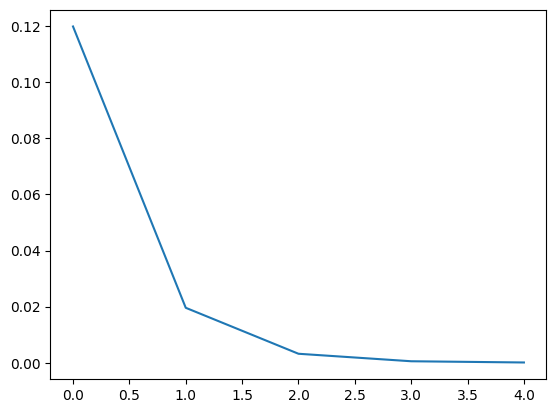

In [542]:
plt.plot(range(5), loss_list[5:])

So, we have now applied both torch.nn.Module and just torch tensors to build simple neural network. We tested the network with a single input of $[3, 1]$ and a single scalar output. However, in reality, inputs to neural networks are passed in batches and the gradients are calculated on batches and weights are updated after each iteration. We shall look at this aspect and try to implement this in raw torch and also using torch.nn.

# Discarded code

In [141]:
# def forward(num_layers, inputs, weights, biases, activ):
#     '''
#     Calculates forward pass for a single layer model (here with 2 inputs and three neurons)  
    
#     inputs: Inputs (tensor)
#     weights: weights of neurons in the first layer (tensor)
#     biases: biases of neurons in first layer (tensor)
#     acitv: activation function (function)
    
#     Returns the output as a tensor
#     '''
    
#     for layer in range(1, num_layers+1):  # Thought of rather than calling forward() again and again will do a for loop
#         # but later realized that the inputs remain same due to the inputs passed as params to forward(). So the second layer's
#         # input is also the input from input layer and not the activation from the first layer
#         print('==============')
#         print('Inputs for layer {}: {}'.format(layer, inputs))

#         print('==============')
#         print('biases for layer {}: {}: '.format(layer, biases))

#         print('==============')
#         print('Weightsfor layer {}: {}:'.format(layer, weights))

#         if weights.shape[1]>1:
#             z = weights@inputs + biases  
#             # This line is the culprit. Have to solve this problem using this function itself or 
#             # will have to keep calling forward again and again. But this mistake was subtle and would not have realized if not
#             # for the so many print statements. Really usefyll!!
            
#             out = activ(z)
#         else:
#             z = torch.dot(weights.ravel(), inputs.ravel()) + biases.ravel()
#             out = activ(z)
#         print('==============')
#         print('Output for layer {}: {}'.format(layer, z))
    
#     return out

In [142]:
# h1 = forward(2, inputs, weights_1, biases_1, sigmoid)
# in the output see that the `input for layer 2` is same as `input for layer 1`, where in reality input for layer 2 should
# activation from the first layer or output of first layer.

Inputs for layer 1: tensor([[ 0.8459],
        [ 0.1651],
        [-2.1057]])
biases for layer 1: tensor([[1.],
        [1.]], requires_grad=True): 
Weightsfor layer 1: tensor([[-1.8574,  0.4155, -0.4989],
        [-1.9424,  1.0353, -0.3785]], requires_grad=True):
Output for layer 1: tensor([[0.5481],
        [0.3249]], grad_fn=<AddBackward0>)
Inputs for layer 2: tensor([[ 0.8459],
        [ 0.1651],
        [-2.1057]])
biases for layer 2: tensor([[1.],
        [1.]], requires_grad=True): 
Weightsfor layer 2: tensor([[-1.8574,  0.4155, -0.4989],
        [-1.9424,  1.0353, -0.3785]], requires_grad=True):
Output for layer 2: tensor([[0.5481],
        [0.3249]], grad_fn=<AddBackward0>)
